In [10]:
from os import sep
import pandas as pd;
import numpy as np;
from scipy import sparse;
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
import math
import seaborn as sns

In [11]:
class collaborative_filering:
    def __init__(self, Y, k_neighbors, distance_func=cosine_similarity, mode=1):
        self.mode = mode;
        if self.mode == 1:
            self.Y = Y
        else:
            self.Y = Y[:, [1, 0, 2]]

        self.k_neighbors = k_neighbors
        self.distance_func = distance_func
        self.Y_utility = None
        self.no_users = 1390
        self.no_movies = 8352

    def insert(self, data):
        self.Y = np.concatenate((self.Y, data), axis=0)

    def normalize_data(self):
        users = self.Y[:, 0]
        self.Y_utility = self.Y.copy()
        self.mean_user = np.zeros((self.no_users, ))
        for i in range(self.no_users):
            user_id_list = np.where(users == i)[0].astype(np.int32)
            item_id_list = self.Y[user_id_list, 1]
            rating_list = self.Y[user_id_list, 2]
            if (len(rating_list) == 0):
                m = 0
            else:
                m = np.mean(rating_list)
                if np.isnan(m):
                    m = 0
            self.mean_user[i] = m
            self.Y_utility[user_id_list, 2] = rating_list - self.mean_user[i]

        self.Y_utility_sparse = sparse.coo_matrix((self.Y_utility[:, 2], (
            self.Y_utility[:, 1], self.Y_utility[:, 0])),  (self.no_movies, self.no_users))
        self.Y_utility_sparse = self.Y_utility_sparse.tocsr()

    def cal_similarity(self):
        self.similarity_matrix = self.distance_func(
            self.Y_utility_sparse.T, self.Y_utility_sparse.T)

    def refresh(self):
        self.normalize_data()
        self.cal_similarity()

    def fit(self):
        self.refresh()

    def predict_utils(self, user, i):
        user = int(user)
        i = int(i)
        user_id_list = np.where(self.Y[:, 1] == i)[0].astype(np.int32)
        user_id_list = (self.Y[user_id_list, 0]).astype(np.int32)
        similar = self.similarity_matrix[user, user_id_list]

        k_user_id_nearest = np.argsort(similar)[-self.k_neighbors:]

        k_simlilar_nearest = similar[k_user_id_nearest]

        r = self.Y_utility_sparse[i, user_id_list[k_user_id_nearest]]

        return (r * k_simlilar_nearest)[0] / (np.abs(k_simlilar_nearest).sum() + 1e-8) + self.mean_user[user]

    def predict(self, user, i):

        if self.mode:
            return self.predict_utils(user, i)
        return self.predict_utils(i, user)

    def suggest(self, user):

        row_id_list = np.where(self.Y[:, 0] == user)[0]
        movie_list = self.Y[row_id_list, 1].tolist()

        res = []

        for i in range(self.no_movies):
            if i not in movie_list:
                rating = self.predict_utils(user, i)

                # if rating > self.mean_user[user]:
                #     res.append(i)
                if rating >= 4.5:
                    res.append(i)

        return res

    def print(self):
        suggest_out_path = '../../result/CF_suggest.csv'
        suggest_list = []
        if self.mode == 0:
            df = pd.DataFrame(columns=['movie index', 'user indexes'])
            df['movie index'] = np.zeros(self.no_users)
            df['user indexes'] = np.zeros(self.no_users)
            for i in range(self.no_users):
                res = self.suggest(i)
                res = [str(i) for i in res]
                suggest_list.append("|".join(res))
                # if self.mode:
                #     print ('Recommend item(s):', res, 'to user', i)
                # else:
                #     print ('Recommend item', i, 'to user(s) : ', res)
            df['user indexes'] = suggest_list
            df['movie index'] = range(self.no_users)
            df.to_csv(suggest_out_path, sep=',', index=False)


In [12]:
class Metrics():
    def computeMSE(y_true, y_pred):
        return np.mean((y_true-y_pred)**2)

    def computeMAE(y_true, y_pred):
        return np.mean(np.abs(y_true-y_pred))

    def computeSIA(y_true, y_pred, eps=1): 
        error = np.abs(y_true - y_pred)
        bina = [1 if err <= eps else 0 for err in error]
        res = np.mean(bina)
        return res


In [13]:
train_path = f'../../data/datasets/rating/kfold/u5.base.csv'
test_path = f'../../data/datasets/rating/kfold/u5.test.csv'
rating_train = pd.read_csv(train_path, sep=',', encoding='latin-1')[['user index', 'movie index', 'rating']].drop_duplicates(subset=['user index', 'movie index'], keep='first').values
rating_test = pd.read_csv(test_path, sep=',', encoding='latin-1')[['user index', 'movie index', 'rating']].drop_duplicates(subset=['user index', 'movie index'], keep='first').values  

In [14]:
CF_model = collaborative_filering(rating_train, k_neighbors=50, mode=1)
CF_model.fit()
no_tests = rating_test.shape[0]
Y_predict = []
for i in range(no_tests):
    predict = CF_model.predict(rating_test[i, 0], rating_test[i, 1])
    if (predict < 1):
        predict = 1
    if (predict > 5):
        predict = 5

    Y_predict.append(predict)

In [15]:
X = [i for i in range(no_tests)]
Y_true = rating_test[:, 2]

In [16]:
print(Metrics.computeMSE(Y_true, Y_predict))
print(Metrics.computeSIA(Y_true, Y_predict))
print(Metrics.computeMAE(Y_true, Y_predict))

0.9818304489681672
0.7259545674238763
0.7607723436740845


C:\Users\Pc\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

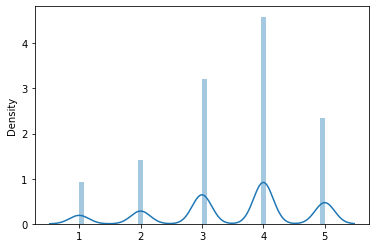

In [17]:
sns.distplot(np.array(Y_true),)

C:\Users\Pc\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

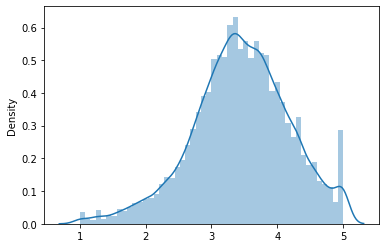

In [18]:
sns.distplot(np.array(Y_predict),)